In [ ]:
# Import necessary libraries
import warnings 
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from scipy.stats import norm
from tqdm.notebook import tqdm
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [51]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

In [52]:
%run ./download_weather_data.py

Elevation: 11.0 masl
Timezone: None None
Timezone difference to GMT+0: 0 s
                           date  temperature_2m
0     2020-08-10 00:00:00+00:00             NaN
1     2020-08-10 01:00:00+00:00             NaN
2     2020-08-10 02:00:00+00:00             NaN
3     2020-08-10 03:00:00+00:00             NaN
4     2020-08-10 04:00:00+00:00             NaN
...                         ...             ...
35395 2024-08-23 19:00:00+00:00       19.717501
35396 2024-08-23 20:00:00+00:00       18.817501
35397 2024-08-23 21:00:00+00:00       17.217501
35398 2024-08-23 22:00:00+00:00       17.267500
35399 2024-08-23 23:00:00+00:00       16.067501

[35400 rows x 2 columns]
                          date  temperature_2m_mean
0    2020-08-10 00:00:00+00:00                  NaN
1    2020-08-11 00:00:00+00:00                  NaN
2    2020-08-12 00:00:00+00:00                  NaN
3    2020-08-13 00:00:00+00:00                  NaN
4    2020-08-14 00:00:00+00:00                  NaN
...        

C:\Users\Lucas\OneDrive - UvA\Documenten\Computational Science\Computational Finance\CompFinance ass 1\CompFinance_ass_1\assignment 2\download_weather_data.py:76: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hourly_dataframe_clean['temperature_2m'] = hourly_dataframe_clean['temperature_2m'].fillna(method='ffill').fillna(method='bfill')
C:\Users\Lucas\OneDrive - UvA\Documenten\Computational Science\Computational Finance\CompFinance ass 1\CompFinance_ass_1\assignment 2\download_weather_data.py:96: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_dataframe_clean['temperature_2m_mean'] = daily_dataframe_clean['temperature_2m_mean'].fillna(method='ffill').fillna(method='bfill')


In [53]:

# Load the data
daily_data = pd.read_csv('daily_data.csv')
daily_data['date'] = pd.to_datetime(daily_data['date'])
daily_data.set_index('date', inplace=True)

# Display the first few rows of the data
print("Daily temperature data:")
daily_data.head()

Daily temperature data:


,temperature_2m_mean
date,
2020-08-10 00:00:00+00:00,6.909751
2020-08-11 00:00:00+00:00,6.909751
2020-08-12 00:00:00+00:00,6.909751
2020-08-13 00:00:00+00:00,6.909751
2020-08-14 00:00:00+00:00,6.909751


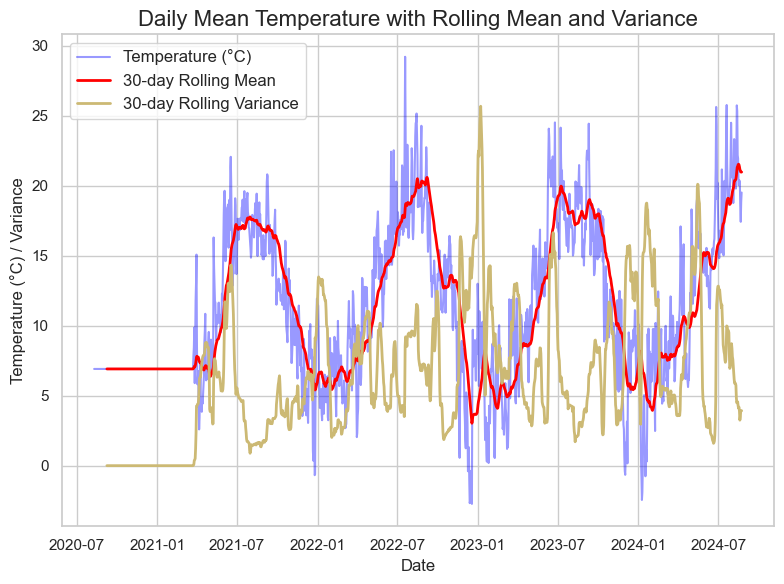

In [54]:
# Plot the time series, rolling mean, and rolling variance
# Calculate rolling statistics
window_size = 30  # 30-day window for monthly patterns
rolling_mean = daily_data['temperature_2m_mean'].rolling(window=window_size).mean()
rolling_var = daily_data['temperature_2m_mean'].rolling(window=window_size).var()

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the original time series
plt.plot(daily_data.index, daily_data['temperature_2m_mean'], label='Temperature (°C)', color='blue', alpha=0.4)

# Plot the rolling mean
plt.plot(daily_data.index, rolling_mean, label=f'{window_size}-day Rolling Mean', color='red', linewidth=2)

# Plot the rolling variance
plt.plot(daily_data.index, rolling_var, label=f'{window_size}-day Rolling Variance', color='y', linewidth=2)

# Add labels and title
plt.title('Daily Mean Temperature with Rolling Mean and Variance', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C) / Variance', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [55]:
# Decompose the time series into trend, seasonality, and residual components
# First, make sure we have no missing values
daily_data = daily_data.dropna()

# Perform seasonal decomposition
# Period=365 for annual seasonality in daily data
decomposition = seasonal_decompose(daily_data['temperature_2m_mean'], model='additive', period=365)

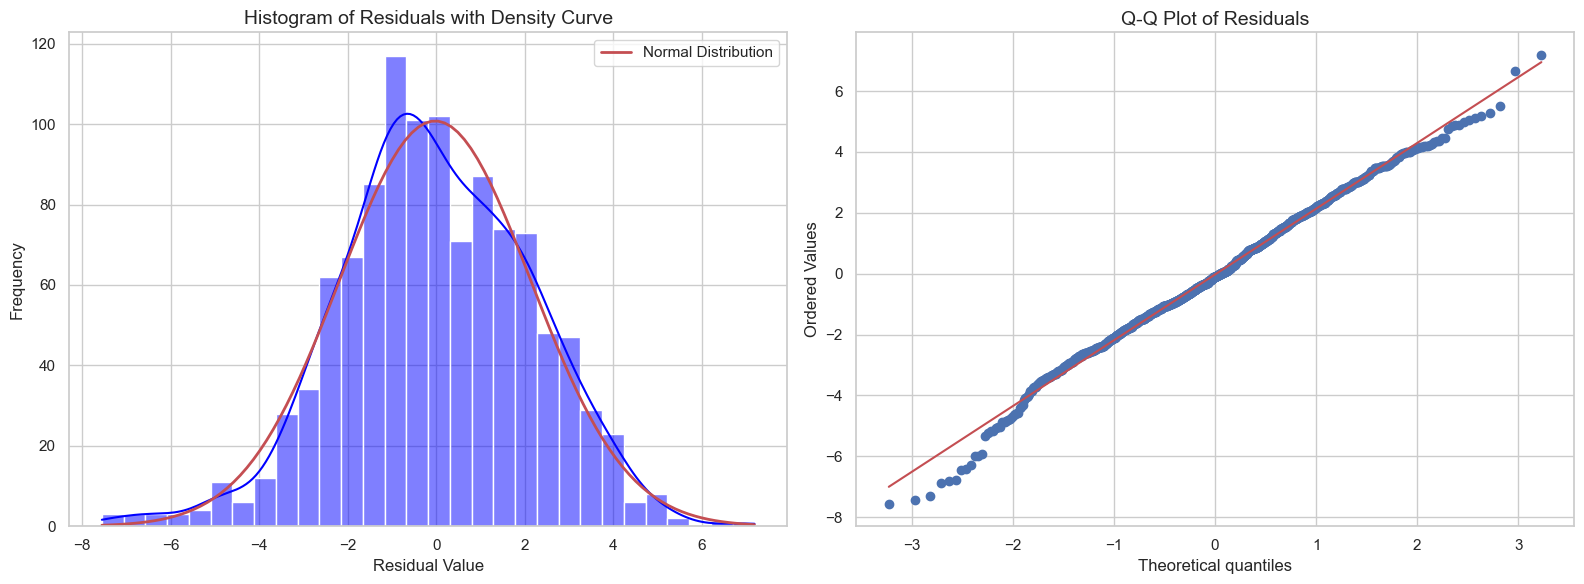

Mean of residuals: -0.0251
Standard deviation of residuals: 2.1620
Skewness: -0.1400
Kurtosis: 0.2598
Jarque-Bera test: statistic=6.7526, p-value=0.0342
Residuals are not normally distributed at 5% significance level


In [56]:
# Visualize the residuals using histograms and Q-Q plots

# Extract residuals from the decomposition
residuals = decomposition.resid.dropna()

# Create a figure with two subplots
plt.figure(figsize=(16, 6))

# Histogram with kernel density estimation
plt.subplot(121)
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title('Histogram of Residuals with Density Curve', fontsize=14)
plt.xlabel('Residual Value')
plt.ylabel('Frequency')

# Add a normal distribution for comparison
x = np.linspace(residuals.min(), residuals.max(), 100)
mean, std = residuals.mean(), residuals.std()
plt.plot(x, stats.norm.pdf(x, mean, std) * len(residuals) * (residuals.max() - residuals.min()) / 30, 
         'r-', linewidth=2, label='Normal Distribution')
plt.legend()

# Q-Q plot
plt.subplot(122)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals', fontsize=14)

plt.tight_layout()
plt.show()

# Additional statistics for residuals
print(f"Mean of residuals: {residuals.mean():.4f}")
print(f"Standard deviation of residuals: {residuals.std():.4f}")
print(f"Skewness: {stats.skew(residuals):.4f}")
print(f"Kurtosis: {stats.kurtosis(residuals):.4f}")

# Jarque-Bera test for normality
jb_stat, jb_pvalue = stats.jarque_bera(residuals)
print(f"Jarque-Bera test: statistic={jb_stat:.4f}, p-value={jb_pvalue:.4f}")
print(f"Residuals are {'normally distributed' if jb_pvalue > 0.05 else 'not normally distributed'} at 5% significance level")

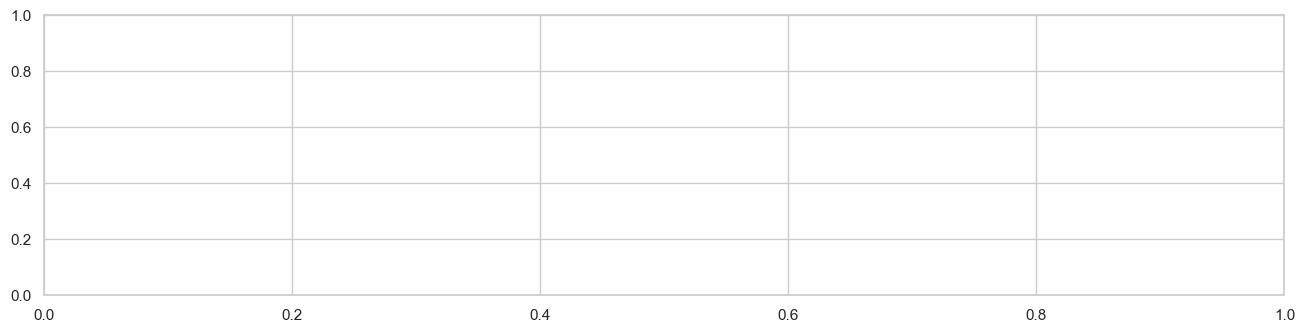

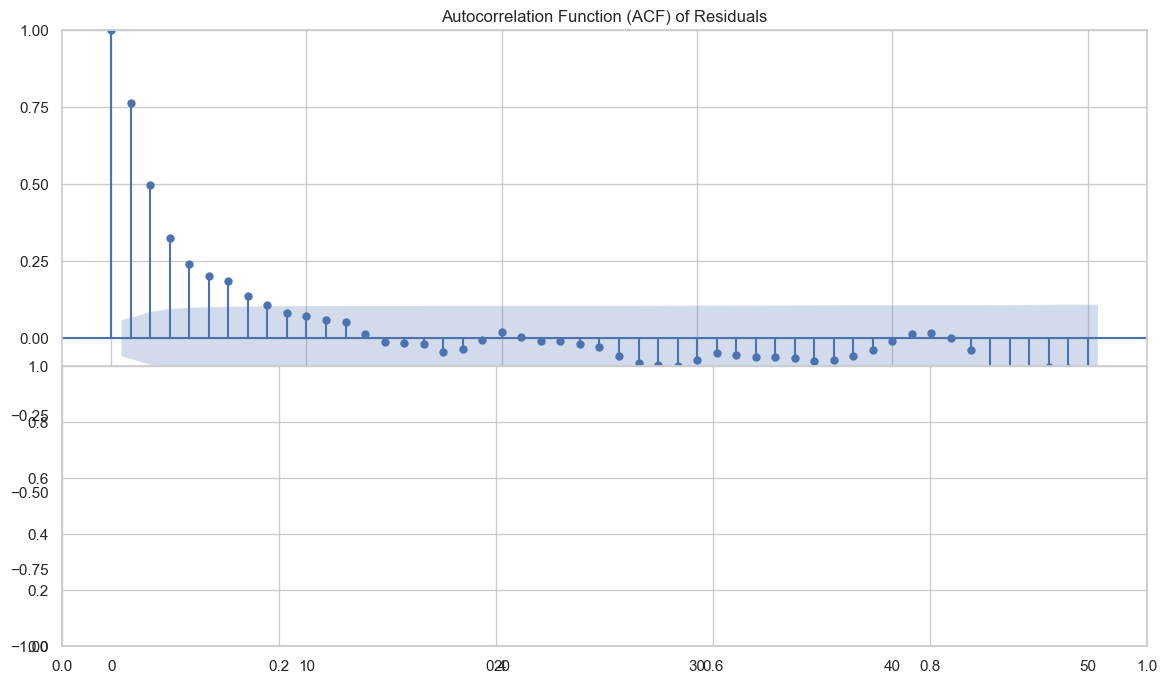

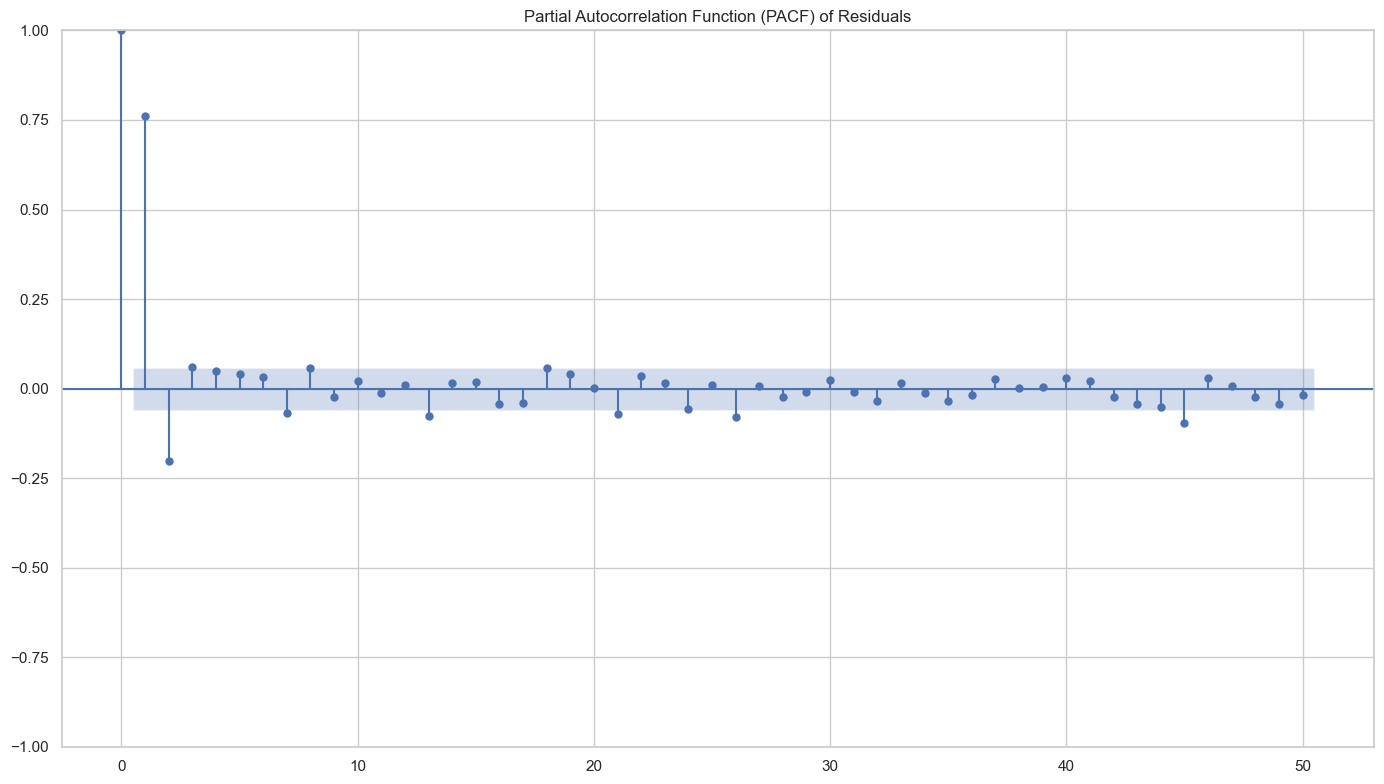

Ljung-Box test (lag=10): statistic=l, p-value=l
Residuals do not have significant autocorrelation at lag 10
Ljung-Box test (lag=20): statistic=l, p-value=l
Residuals do not have significant autocorrelation at lag 20
Ljung-Box test (lag=30): statistic=l, p-value=l
Residuals do not have significant autocorrelation at lag 30


In [57]:
# Compute the autocorrelation (ACF) and partial autocorrelation (PACF) plots

# Create a figure with two subplots
plt.figure(figsize=(16, 8))

# ACF plot
plt.subplot(211)
plot_acf(residuals, lags=50, alpha=0.05, title='Autocorrelation Function (ACF) of Residuals')

# PACF plot
plt.subplot(212)
plot_pacf(residuals, lags=50, alpha=0.05, method='ywm', title='Partial Autocorrelation Function (PACF) of Residuals')

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation

# Test for autocorrelation at different lags
lags = [10, 20, 30]
for lag in lags:
    lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=[lag])
    # Convert to float if needed and handle formatting
    try:
        stat_value = float(lb_stat[0])
        p_value = float(lb_pvalue[0])
        print(f"Ljung-Box test (lag={lag}): statistic={stat_value:.4f}, p-value={p_value:.4f}")
        print(f"Residuals {'have' if p_value < 0.05 else 'do not have'} significant autocorrelation at lag {lag}")
    except (ValueError, TypeError):
        # Handle case where values are strings or other non-float types
        print(f"Ljung-Box test (lag={lag}): statistic={lb_stat[0]}, p-value={lb_pvalue[0]}")
        print(f"Residuals {'have' if str(lb_pvalue[0]).lower() < '0.05' else 'do not have'} significant autocorrelation at lag {lag}")

In [58]:
# Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series.dropna())
    print('Augmented Dickey-Fuller Test:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    print(f"Result: {'Stationary' if result[1] < 0.05 else 'Non-stationary'} at 5% significance level")
    return result

# KPSS test
def kpss_test(series):
    result = kpss(series.dropna())
    print('\nKPSS Test:')
    print(f'KPSS Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[3].items():
        print(f'\t{key}: {value:.4f}')
    print(f"Result: {'Non-stationary' if result[1] < 0.05 else 'Stationary'} at 5% significance level")
    return result

# Run both tests on the residuals
print("Testing stationarity of residuals:")
adf_result = adf_test(residuals)
kpss_result = kpss_test(residuals)

# Also test the original time series for comparison
print("\nTesting stationarity of original temperature time series:")
adf_test(daily_data['temperature_2m_mean'])
kpss_test(daily_data['temperature_2m_mean'])

Testing stationarity of residuals:
Augmented Dickey-Fuller Test:
ADF Statistic: -6.8741
p-value: 0.0000
Critical Values:
	1%: -3.4364
	5%: -2.8642
	10%: -2.5682
Result: Stationary at 5% significance level

KPSS Test:
KPSS Statistic: 0.0402
p-value: 0.1000
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Result: Stationary at 5% significance level

Testing stationarity of original temperature time series:
Augmented Dickey-Fuller Test:
ADF Statistic: -2.0159
p-value: 0.2796
Critical Values:
	1%: -3.4349
	5%: -2.8635
	10%: -2.5678
Result: Non-stationary at 5% significance level

KPSS Test:
KPSS Statistic: 0.5171
p-value: 0.0378
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Result: Non-stationary at 5% significance level


C:\Users\Lucas\AppData\Local\Temp\ipykernel_18204\184350009.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna())


(0.5170716552926663,
 0.03782169925840849,
 24,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Fitted Parameters:
a (baseline temperature): 9.2510
b (linear trend): 0.002625 °C/day
b (linear trend): 0.958955 °C/year
alpha (seasonal amplitude): -6.1239
theta (phase shift): -1.2732 radians
theta (phase shift): -72.95 degrees


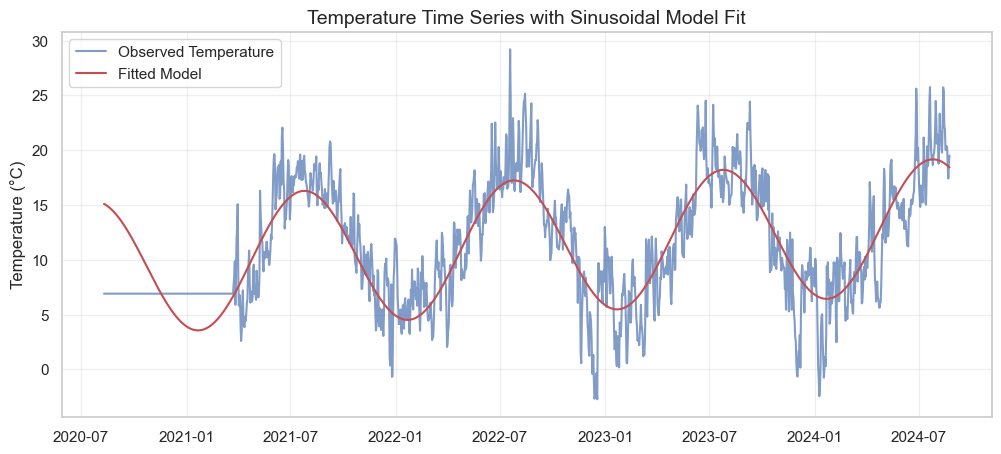


Residual Statistics:
Mean of residuals: 0.0000
Standard deviation: 3.1786
Min residual: -9.4980
Max residual: 12.0025

Stationarity Tests for Model Residuals:
Augmented Dickey-Fuller Test:
ADF Statistic: -8.4955
p-value: 0.0000
Critical Values:
	1%: -3.4348
	5%: -2.8635
	10%: -2.5678
Result: Stationary at 5% significance level

KPSS Test:
KPSS Statistic: 0.2482
p-value: 0.1000
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Result: Stationary at 5% significance level


C:\Users\Lucas\AppData\Local\Temp\ipykernel_18204\2926765666.py:107: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series)


In [59]:
# Define the sinusoidal model function
def temperature_model(t, a, b, alpha, theta):
    """
    Model: T(t) = a + bt + alpha * sin(2π/365.25 * t + theta)
    
    Parameters:
    - t: time in days from the start
    - a: baseline temperature
    - b: linear trend coefficient
    - alpha: amplitude of seasonal component
    - theta: phase shift
    
    Returns:
    - Temperature value
    """
    return a + b * t + alpha * np.sin(2 * np.pi / 365.25 * t + theta)

# Load the daily temperature data
daily_data = pd.read_csv('daily_data.csv')
daily_data['date'] = pd.to_datetime(daily_data['date'])

# Create a time variable (days since start)
start_date = daily_data['date'].min()
daily_data['days'] = (daily_data['date'] - start_date).dt.days

# Extract x and y data for fitting
x_data = daily_data['days'].values
y_data = daily_data['temperature_2m_mean'].values

# Initial parameter guesses
# a: mean temperature, b: small trend, alpha: half the range, theta: 0
initial_guess = [
    np.mean(y_data),  # a: baseline temperature
    0.0001,           # b: small linear trend
    (np.max(y_data) - np.min(y_data)) / 2,  # alpha: amplitude
    0                 # theta: phase shift
]

# Fit the model using curve_fit
params, params_covariance = curve_fit(
    temperature_model, 
    x_data, 
    y_data, 
    p0=initial_guess,
    maxfev=10000  # Increase max function evaluations if needed
)

# Extract the fitted parameters
a_fit, b_fit, alpha_fit, theta_fit = params

# Print the fitted parameters
print("Fitted Parameters:")
print(f"a (baseline temperature): {a_fit:.4f}")
print(f"b (linear trend): {b_fit:.6f} °C/day")
print(f"b (linear trend): {b_fit*365.25:.6f} °C/year")
print(f"alpha (seasonal amplitude): {alpha_fit:.4f}")
print(f"theta (phase shift): {theta_fit:.4f} radians")
print(f"theta (phase shift): {theta_fit * 180/np.pi:.2f} degrees")

# Calculate the model fit
y_fit = temperature_model(x_data, *params)

# Extract residuals
residuals = y_data - y_fit

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'date': daily_data['date'],
    'observed': y_data,
    'fitted': y_fit,
    'residuals': residuals
})

plt.figure(figsize=(12, 5))
plt.plot(daily_data['date'], y_data, 'b-', alpha=0.7, label='Observed Temperature')
plt.plot(daily_data['date'], y_fit, 'r-', label='Fitted Model')
plt.title('Temperature Time Series with Sinusoidal Model Fit', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate statistics for the residuals
print("\nResidual Statistics:")
print(f"Mean of residuals: {np.mean(residuals):.4f}")
print(f"Standard deviation: {np.std(residuals):.4f}")
print(f"Min residual: {np.min(residuals):.4f}")
print(f"Max residual: {np.max(residuals):.4f}")

# Test for stationarity of residuals
print("\nStationarity Tests for Model Residuals:")

# Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print('Augmented Dickey-Fuller Test:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    print(f"Result: {'Stationary' if result[1] < 0.05 else 'Non-stationary'} at 5% significance level")
    return result

# KPSS test
def kpss_test(series):
    result = kpss(series)
    print('\nKPSS Test:')
    print(f'KPSS Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[3].items():
        print(f'\t{key}: {value:.4f}')
    print(f"Result: {'Non-stationary' if result[1] < 0.05 else 'Stationary'} at 5% significance level")
    return result

# Run stationarity tests on the residuals
adf_result = adf_test(residuals)
kpss_result = kpss_test(residuals)

In [60]:
# Additional analysis: Compare model components with seasonal decomposition

# Create a time series for decomposition
ts = pd.Series(y_data, index=daily_data['date'])

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts, model='additive', period=365)

# Create time variables for plotting
time_range = daily_data['date']

# Extract components from decomposition
trend = decomposition.trend
seasonal = decomposition.seasonal
decomp_residual = decomposition.resid

# Create model components
baseline = a_fit + b_fit * x_data  # Trend component from our model
seasonal_component = alpha_fit * np.sin(2 * np.pi / 365.25 * x_data + theta_fit)  # Seasonal component


# Calculate goodness of fit metrics
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_data, y_fit)
rmse = np.sqrt(mse)
r2 = r2_score(y_data, y_fit)

print("\nGoodness of Fit Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Goodness of Fit Metrics:
Mean Squared Error (MSE): 10.1033
Root Mean Squared Error (RMSE): 3.1786
R-squared (R²): 0.6736


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_18204\2892839004.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided


Optimal AR order based on AIC: 30
Optimal AR order based on BIC: 5
Elbow point (where AIC improvements become marginal): AR(7)


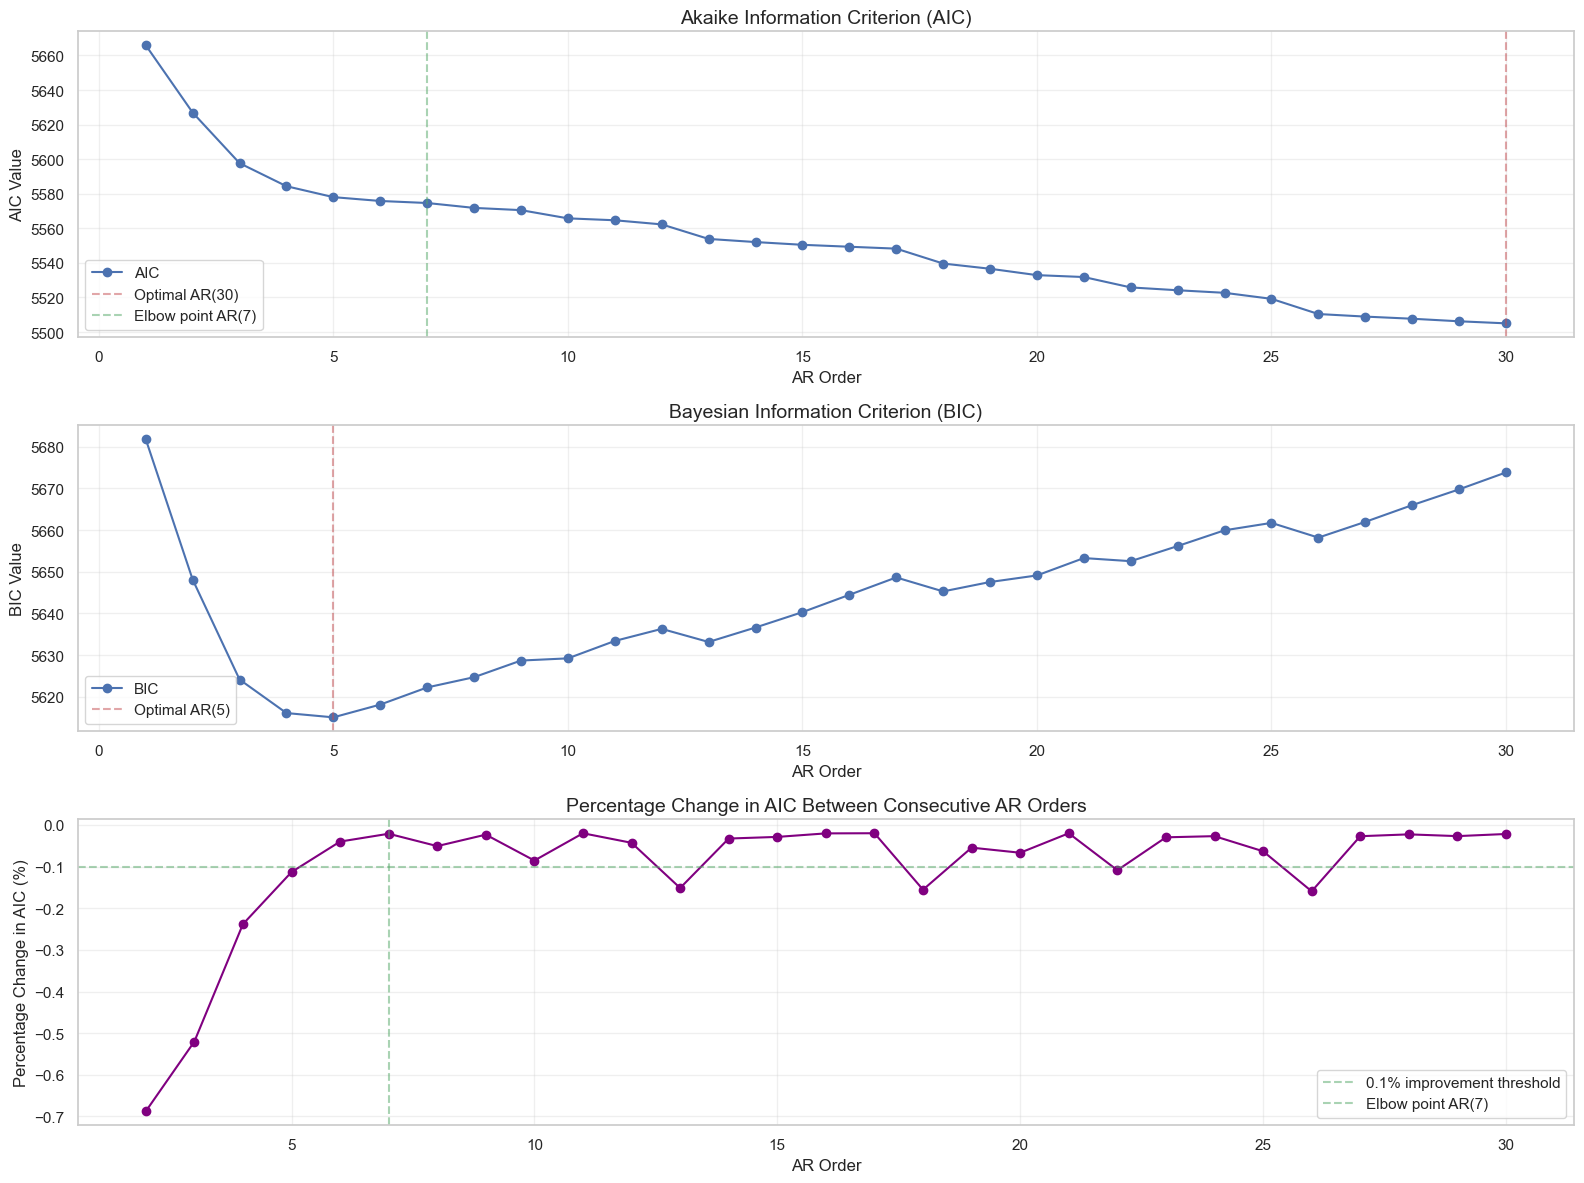


Recommendation:
Based on the analysis, an AR(7) model provides a good balance between
model complexity and explanatory power. BIC suggests a more parsimonious model
with AR(5), while AIC favors a more complex model.
For time series forecasting, the elbow point approach often provides a practical compromise.


In [61]:

residuals_series = pd.Series(residuals, index=daily_data['date'])


# Determine the order of the AR process using information criteria with a wider range
def compare_ar_models(series, max_lag=30):
    results = pd.DataFrame(columns=['AR_Order', 'AIC', 'BIC', 'HQIC', 'Log_Likelihood'])
    
    for p in range(1, max_lag + 1):
        model = AutoReg(series, lags=p)
        model_fit = model.fit()
        
        results = pd.concat([results, pd.DataFrame({
            'AR_Order': [p],
            'AIC': [model_fit.aic],
            'BIC': [model_fit.bic],
            'HQIC': [model_fit.hqic],
            'Log_Likelihood': [model_fit.llf]
        })], ignore_index=True)
    
    return results

# Compare AR models with a wider range of orders
ar_comparison = compare_ar_models(residuals_series.dropna(), max_lag=30)

# Find the optimal AR order based on different criteria
optimal_ar_order_aic = ar_comparison.loc[ar_comparison['AIC'].idxmin(), 'AR_Order']
optimal_ar_order_bic = ar_comparison.loc[ar_comparison['BIC'].idxmin(), 'AR_Order']

# Calculate the rate of change in AIC to find the "elbow point"
ar_comparison['AIC_diff'] = ar_comparison['AIC'].diff()
ar_comparison['AIC_pct_change'] = ar_comparison['AIC'].pct_change() * 100

# Find where the improvement becomes marginal (less than 0.1% improvement)
elbow_points = ar_comparison[ar_comparison['AIC_pct_change'] > -0.1].iloc[1:] if len(ar_comparison) > 1 else ar_comparison
elbow_order = int(elbow_points['AR_Order'].iloc[0]) if not elbow_points.empty else int(optimal_ar_order_bic)

print(f"\nOptimal AR order based on AIC: {int(optimal_ar_order_aic)}")
print(f"Optimal AR order based on BIC: {int(optimal_ar_order_bic)}")
print(f"Elbow point (where AIC improvements become marginal): AR({elbow_order})")

# Plot the information criteria with annotations
plt.figure(figsize=(16, 12))

# Plot AIC
plt.subplot(311)
plt.plot(ar_comparison['AR_Order'], ar_comparison['AIC'], 'o-', label='AIC')
plt.axvline(x=optimal_ar_order_aic, color='r', linestyle='--', alpha=0.5, 
            label=f'Optimal AR({int(optimal_ar_order_aic)})')
plt.axvline(x=elbow_order, color='g', linestyle='--', alpha=0.5, 
            label=f'Elbow point AR({elbow_order})')
plt.title('Akaike Information Criterion (AIC)', fontsize=14)
plt.xlabel('AR Order')
plt.ylabel('AIC Value')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot BIC
plt.subplot(312)
plt.plot(ar_comparison['AR_Order'], ar_comparison['BIC'], 'o-', label='BIC')
plt.axvline(x=optimal_ar_order_bic, color='r', linestyle='--', alpha=0.5, 
            label=f'Optimal AR({int(optimal_ar_order_bic)})')
plt.title('Bayesian Information Criterion (BIC)', fontsize=14)
plt.xlabel('AR Order')
plt.ylabel('BIC Value')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot the percentage change in AIC
plt.subplot(313)
plt.plot(ar_comparison['AR_Order'][1:], ar_comparison['AIC_pct_change'][1:], 'o-', color='purple')
plt.axhline(y=-0.1, color='g', linestyle='--', alpha=0.5, label='0.1% improvement threshold')
plt.axvline(x=elbow_order, color='g', linestyle='--', alpha=0.5, label=f'Elbow point AR({elbow_order})')
plt.title('Percentage Change in AIC Between Consecutive AR Orders', fontsize=14)
plt.xlabel('AR Order')
plt.ylabel('Percentage Change in AIC (%)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Recommend a balanced approach
print("\nRecommendation:")
print(f"Based on the analysis, an AR({elbow_order}) model provides a good balance between")
print("model complexity and explanatory power. BIC suggests a more parsimonious model")
print(f"with AR({int(optimal_ar_order_bic)}), while AIC favors a more complex model.")
print("For time series forecasting, the elbow point approach often provides a practical compromise.")

In [62]:
# Fit the optimal AR model and estimate the mean-reversion parameter κ

# We'll use the optimal order from AIC (usually AIC is preferred for time series)
optimal_order = int(elbow_order)

# Fit the AR model with the optimal order
model = AutoReg(residuals_series.dropna(), lags=optimal_order)
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Extract AR coefficients
ar_coefficients = model_fit.params[1:]  # Skip the constant term
print("\nAR Coefficients:")
for i, coef in enumerate(ar_coefficients):
    print(f"AR{i+1}: {coef:.6f}")

# Calculate the mean-reversion parameter κ for an AR(1) process
# For an AR(1) process: x_t = c + φ*x_{t-1} + ε_t
# The mean-reversion parameter κ = -ln(φ)
if optimal_order >= 1:
    phi1 = ar_coefficients[0]  # First AR coefficient
    kappa = -np.log(abs(phi1))
    half_life = np.log(2) / kappa
    
    print("\nMean-Reversion Analysis:")
    print(f"First AR coefficient (φ): {phi1:.6f}")
    print(f"Mean-reversion parameter (κ): {kappa:.6f}")
    print(f"Half-life of mean-reversion: {half_life:.2f} days")
    
    # Interpretation
    if phi1 > 0 and phi1 < 1:
        print("\nThe process is stationary and mean-reverting.")
        print(f"A shock to the system will decay by 50% in approximately {half_life:.2f} days.")
    elif phi1 == 1:
        print("\nThe process is a random walk (no mean-reversion).")
    elif phi1 > 1:
        print("\nThe process is explosive (not mean-reverting).")
    elif phi1 < 0:
        print("\nThe process is mean-reverting with oscillations.")
else:
    print("\nThe optimal model is not an AR(1), so the simple mean-reversion interpretation doesn't apply directly.")

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1475
Model:                     AutoReg(7)   Log Likelihood               -2778.316
Method:               Conditional MLE   S.D. of innovations              1.606
Date:                Sun, 11 May 2025   AIC                           5574.632
Time:                        20:08:32   BIC                           5622.257
Sample:                    08-17-2020   HQIC                          5592.393
                         - 08-23-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0115      0.042      0.275      0.784      -0.071       0.094
y.L1           0.9878      0.026     37.852      0.000       0.937       1.039
y.L2          -0.2710      0.037     -7.389      0.0

c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [63]:
# For higher-order AR processes, we need to analyze the characteristic polynomial
if optimal_order > 1:
    print("\nAnalysis for higher-order AR process:")
    
    # Create the characteristic polynomial
    # For an AR(p) process, the characteristic polynomial is: 1 - φ₁z - φ₂z² - ... - φₚzᵖ
    ar_poly = np.concatenate([[1], -ar_coefficients])
    
    # Find the roots of the characteristic polynomial
    roots = np.roots(ar_poly)
    
    # Calculate the moduli of the roots
    moduli = np.abs(roots)
    
    # Print the roots and their moduli
    print("\nRoots of the characteristic polynomial:")
    for i, (root, modulus) in enumerate(zip(roots, moduli)):
        print(f"Root {i+1}: {root:.4f} (modulus: {modulus:.4f})")
    
    # Check stationarity
    if all(modulus > 1 for modulus in moduli):
        print("\nThe AR process is stationary as all roots lie outside the unit circle.")
        
        # For AR(p), the mean-reversion speed is determined by the dominant root
        dominant_root = min(moduli)
        kappa_approx = -np.log(dominant_root)
        half_life_approx = np.log(2) / kappa_approx
        
        print(f"\nApproximate mean-reversion parameter (κ) based on dominant root: {kappa_approx:.6f}")
        print(f"Approximate half-life of mean-reversion: {half_life_approx:.2f} days")
    else:
        print("\nThe AR process is not stationary as at least one root lies inside or on the unit circle.")


Analysis for higher-order AR process:

Roots of the characteristic polynomial:
Root 1: 0.9032+0.0000j (modulus: 0.9032)
Root 2: 0.3821+0.5073j (modulus: 0.6351)
Root 3: 0.3821-0.5073j (modulus: 0.6351)
Root 4: -0.1302+0.3999j (modulus: 0.4205)
Root 5: -0.1302-0.3999j (modulus: 0.4205)
Root 6: -0.3487+0.0000j (modulus: 0.3487)
Root 7: -0.0704+0.0000j (modulus: 0.0704)

The AR process is not stationary as at least one root lies inside or on the unit circle.


                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1475
Model:                     AutoReg(7)   Log Likelihood               -2778.316
Method:               Conditional MLE   S.D. of innovations              1.606
Date:                Sun, 11 May 2025   AIC                           5574.632
Time:                        20:08:32   BIC                           5622.257
Sample:                    08-17-2020   HQIC                          5592.393
                         - 08-23-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0115      0.042      0.275      0.784      -0.071       0.094
y.L1           0.9878      0.026     37.852      0.000       0.937       1.039
y.L2          -0.2710      0.037     -7.389      0.0

c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


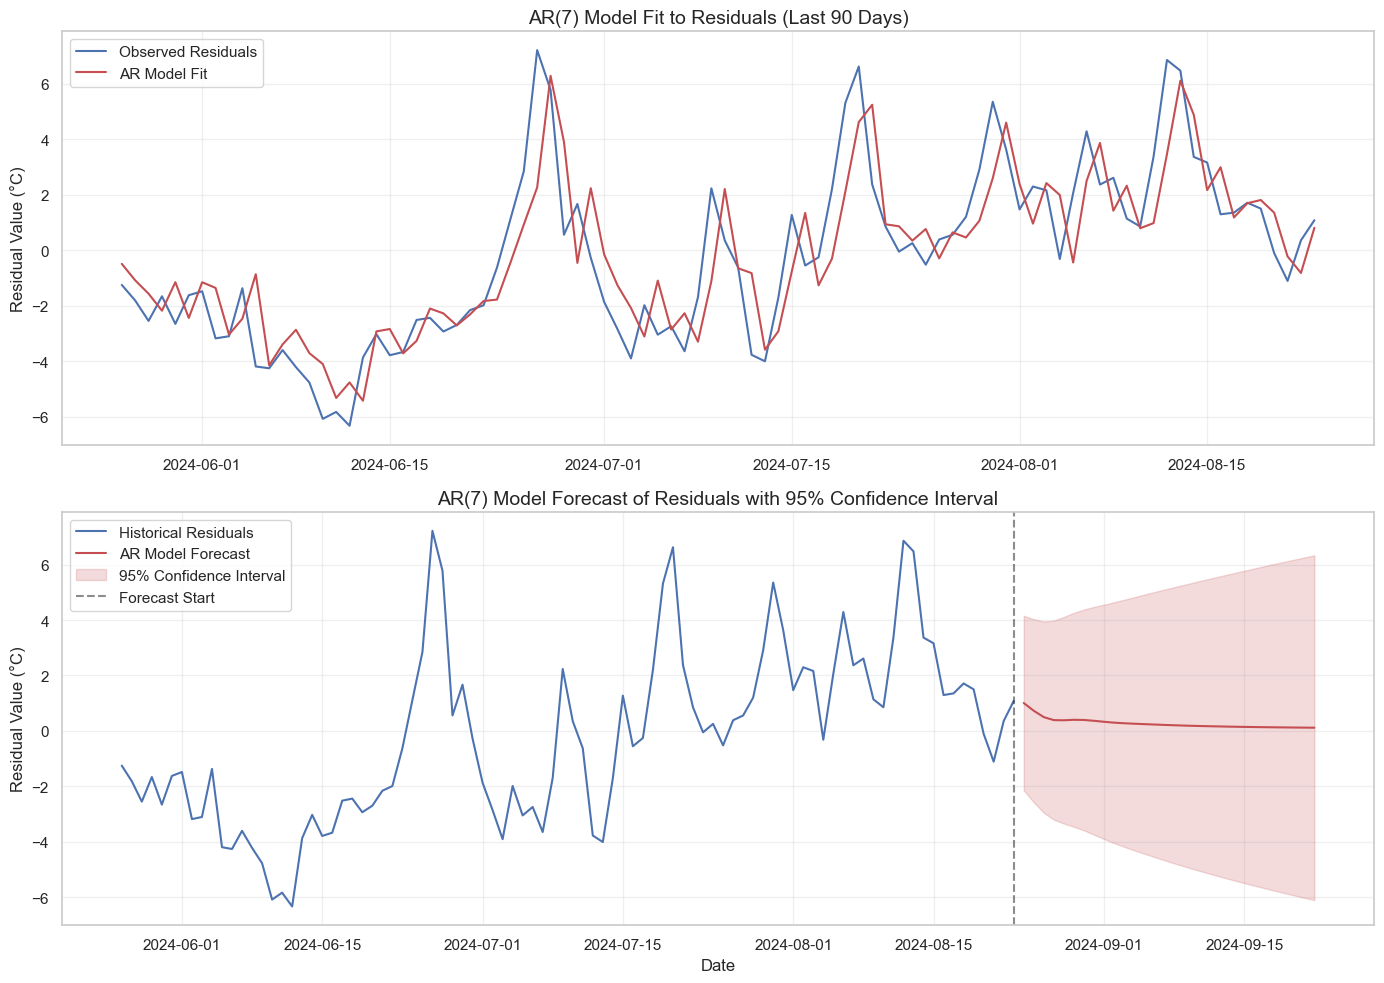


AR Coefficients:
AR1: 0.987819
AR2: -0.271048
AR3: 0.058482
AR4: 0.037852
AR5: 0.032347
AR6: 0.024585
AR7: 0.001583

Mean-Reversion Analysis:
Sum of AR coefficients: 0.871619
Approximate mean-reversion parameter (κ): 0.137403
Approximate half-life of mean-reversion: 5.04 days

Roots of the characteristic polynomial:
Root 1: 0.9032+0.0000j (modulus: 0.9032)
Root 2: 0.3821+0.5073j (modulus: 0.6351)
Root 3: 0.3821-0.5073j (modulus: 0.6351)
Root 4: -0.1302+0.3999j (modulus: 0.4205)
Root 5: -0.1302-0.3999j (modulus: 0.4205)
Root 6: -0.3487+0.0000j (modulus: 0.3487)
Root 7: -0.0704+0.0000j (modulus: 0.0704)

The AR process is stationary as all roots lie inside the unit circle.


In [64]:
elbow_order = 7  

# Ensure residuals_series has a datetime index
residuals_series = pd.Series(residuals, index=daily_data['date'])
model = AutoReg(residuals_series.dropna(), lags=elbow_order)
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Generate fitted values
fitted_values = model_fit.fittedvalues

# Generate forecasts for the next 30 days with confidence intervals
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# Get the standard error of the model to calculate confidence intervals
sigma = np.sqrt(model_fit.sigma2)

# Calculate confidence intervals (95%)
from scipy import stats
alpha = 0.05  # 95% confidence interval
z = stats.norm.ppf(1 - alpha/2)  # z-score for 95% confidence

# Initialize arrays for confidence bounds
lower_ci = np.zeros(forecast_steps)
upper_ci = np.zeros(forecast_steps)

# Calculate confidence intervals for each forecast step
# For AR models, forecast uncertainty grows with the horizon
for i in range(forecast_steps):
    # For simplicity, we'll use a growing uncertainty based on the step
    # This is an approximation - for exact values, you'd need to compute the forecast error variance
    forecast_std = sigma * np.sqrt(1 + i * 0.1)  # Growing uncertainty with forecast horizon
    lower_ci[i] = forecast[i] - z * forecast_std
    upper_ci[i] = forecast[i] + z * forecast_std

# Create a date range for the forecast
last_date = residuals_series.dropna().index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps)

# Create a single figure with two subplots
plt.figure(figsize=(14, 10))

# Subplot 1: Model fit for the last 90 days
plt.subplot(211)
# Get the last 90 days of data
last_90_days = residuals_series.dropna()[-90:]
last_90_days_fitted = fitted_values[-90:]

plt.plot(last_90_days.index, last_90_days, 'b-', label='Observed Residuals')
plt.plot(last_90_days.index, last_90_days_fitted, 'r-', label='AR Model Fit')
plt.title(f'AR({elbow_order}) Model Fit to Residuals (Last 90 Days)', fontsize=14)
plt.ylabel('Residual Value (°C)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Forecast for the next 30 days, with historical context and confidence intervals
plt.subplot(212)
plt.plot(last_90_days.index, last_90_days, 'b-', label='Historical Residuals')
plt.plot(forecast_dates, forecast, 'r-', label='AR Model Forecast')
plt.fill_between(forecast_dates, lower_ci, upper_ci, color='r', alpha=0.2, label='95% Confidence Interval')
plt.axvline(x=last_date, color='k', linestyle='--', alpha=0.5, label='Forecast Start')
plt.title(f'AR({elbow_order}) Model Forecast of Residuals with 95% Confidence Interval', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Residual Value (°C)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate the mean-reversion parameter κ for the AR(7) model
ar_coefficients = model_fit.params[1:]  # Skip the constant term
print("\nAR Coefficients:")
for i, coef in enumerate(ar_coefficients):
    print(f"AR{i+1}: {coef:.6f}")

# For AR(p) processes, we can approximate κ using the sum of AR coefficients
phi_sum = sum(ar_coefficients)
kappa_approx = -np.log(abs(phi_sum))
half_life_approx = np.log(2) / kappa_approx if kappa_approx > 0 else float('inf')

print("\nMean-Reversion Analysis:")
print(f"Sum of AR coefficients: {phi_sum:.6f}")
print(f"Approximate mean-reversion parameter (κ): {kappa_approx:.6f}")
print(f"Approximate half-life of mean-reversion: {half_life_approx:.2f} days")

# Analyze the characteristic polynomial for stationarity
ar_poly = np.concatenate([[1], -ar_coefficients])
roots = np.roots(ar_poly)
moduli = np.abs(roots)

print("\nRoots of the characteristic polynomial:")
for i, (root, modulus) in enumerate(zip(roots, moduli)):
    print(f"Root {i+1}: {root:.4f} (modulus: {modulus:.4f})")

# Correct the stationarity check (roots should be INSIDE the unit circle for stationarity)
if all(modulus < 1 for modulus in moduli):
    print("\nThe AR process is stationary as all roots lie inside the unit circle.")
else:
    print("\nThe AR process is not stationary as at least one root lies on or outside the unit circle.")

In [65]:
# Develop a simulation algorithm based on an Euler discretization scheme

# Set random seed for reproducibility
np.random.seed(42)

# Define the parameters from the previously calibrated models
# Deterministic sinusoidal model parameters
a_fit = a_fit  # Baseline temperature
b_fit = b_fit  # Linear trend coefficient
alpha_fit = alpha_fit  # Seasonal amplitude
theta_fit = theta_fit  # Phase shift

# AR model parameters for residuals
ar_coefficients = model_fit.params[1:]  # Skip the constant term
ar_constant = model_fit.params[0]  # Constant term
sigma = np.sqrt(model_fit.sigma2)  # Standard deviation of residuals

# Print the parameters being used for simulation
print("Deterministic Model Parameters:")
print(f"a (baseline temperature): {a_fit:.4f}")
print(f"b (linear trend): {b_fit:.6f} °C/day")
print(f"alpha (seasonal amplitude): {alpha_fit:.4f}")
print(f"theta (phase shift): {theta_fit:.4f} radians")

print("\nStochastic Model Parameters:")
print(f"AR constant: {ar_constant:.6f}")
for i, coef in enumerate(ar_coefficients):
    print(f"AR{i+1}: {coef:.6f}")
print(f"Residual standard deviation (sigma): {sigma:.4f}")

# Mean-reversion parameter
kappa = -np.log(abs(sum(ar_coefficients)))
print(f"Mean-reversion parameter (κ): {kappa:.6f}")

Deterministic Model Parameters:
a (baseline temperature): 9.2510
b (linear trend): 0.002625 °C/day
alpha (seasonal amplitude): -6.1239
theta (phase shift): -1.2732 radians

Stochastic Model Parameters:
AR constant: 0.011514
AR1: 0.987819
AR2: -0.271048
AR3: 0.058482
AR4: 0.037852
AR5: 0.032347
AR6: 0.024585
AR7: 0.001583
Residual standard deviation (sigma): 1.6058
Mean-reversion parameter (κ): 0.137403


In [66]:
# Suppress specific FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning, message='Series.__getitem__ treating keys as positions is deprecated')

# Set random seed for reproducibility
np.random.seed(42)

# Define the parameters from the previously calibrated models
# Deterministic sinusoidal model parameters
a_fit = a_fit  # Baseline temperature
b_fit = b_fit  # Linear trend coefficient
alpha_fit = alpha_fit  # Seasonal amplitude
theta_fit = theta_fit  # Phase shift

# AR model parameters for residuals
ar_coefficients = model_fit.params[1:]  # Skip the constant term
ar_constant = model_fit.params[0]  # Constant term
sigma = np.sqrt(model_fit.sigma2)  # Standard deviation of residuals

# Print the parameters being used for simulation
print("Deterministic Model Parameters:")
print(f"a (baseline temperature): {a_fit:.4f}")
print(f"b (linear trend): {b_fit:.6f} °C/day")
print(f"alpha (seasonal amplitude): {alpha_fit:.4f}")
print(f"theta (phase shift): {theta_fit:.4f} radians")

print("\nStochastic Model Parameters:")
print(f"AR constant: {ar_constant:.6f}")
for i, coef in enumerate(ar_coefficients):
    print(f"AR{i+1}: {coef:.6f}")
print(f"Residual standard deviation (sigma): {sigma:.4f}")

# Mean-reversion parameter
kappa = -np.log(abs(sum(ar_coefficients)))
print(f"Mean-reversion parameter (κ): {kappa:.6f}")

# Estimate seasonal volatility using Fourier series
# Extract squared residuals for volatility modeling
squared_residuals = residuals**2

# Create day of year variable (normalized to [0,1])
dates = daily_data['date']
day_of_year = dates.dt.dayofyear
day_of_year_norm = (day_of_year - 1) / 365.25

# Define Fourier series function for volatility
def fourier_volatility(t, params):
    """
    Model volatility using Fourier series
    
    Parameters:
    -----------
    t : array-like
        Time points (normalized day of year, 0-1)
    params : array-like
        Parameters [a0, a1, b1, a2, b2, ..., an, bn]
        
    Returns:
    --------
    Volatility values at each time point
    """
    # Extract parameters
    a0 = params[0]
    a_terms = params[1::2]  # a1, a2, a3, ...
    b_terms = params[2::2]  # b1, b2, b3, ...
    
    # Number of harmonics
    n_harmonics = len(a_terms)
    
    # Initialize volatility with constant term
    volatility = a0 * np.ones_like(t, dtype=float)
    
    # Add Fourier terms
    for i in range(n_harmonics):
        k = i + 1  # Harmonic number
        volatility += a_terms[i] * np.cos(2 * np.pi * k * t)
        volatility += b_terms[i] * np.sin(2 * np.pi * k * t)
    
    # Ensure volatility is positive
    return np.exp(volatility)

# Define negative log-likelihood function
def negative_log_likelihood(params, t, squared_residuals):
    """
    Calculate negative log-likelihood for GARCH-type model with Fourier volatility
    """
    # Calculate volatility using Fourier series
    sigma2 = fourier_volatility(t, params)
    
    # Calculate log-likelihood (assuming Gaussian innovations)
    ll = -0.5 * np.sum(np.log(sigma2) + squared_residuals / sigma2)
    
    # Return negative log-likelihood (for minimization)
    return -ll

# Number of harmonics to include in Fourier series
n_harmonics = 2  # Start with 2 harmonics

# Initial parameter values [a0, a1, b1, a2, b2, ...]
initial_params = np.zeros(1 + 2 * n_harmonics)
initial_params[0] = np.log(np.mean(squared_residuals))  # Initial constant term

# Fit the model using maximum likelihood
print("\nFitting seasonal volatility model with Fourier series...")
result = minimize(
    negative_log_likelihood,
    initial_params,
    args=(day_of_year_norm, squared_residuals),
    method='BFGS',
    options={'disp': True}
)

# Extract optimal parameters
fourier_params = result.x
print("\nOptimal Fourier parameters for seasonal volatility:")
print(f"Constant term (a0): {fourier_params[0]:.4f}")
for i in range(n_harmonics):
    print(f"Harmonic {i+1}: a{i+1} = {fourier_params[2*i+1]:.4f}, b{i+1} = {fourier_params[2*i+2]:.4f}")

Deterministic Model Parameters:
a (baseline temperature): 9.2510
b (linear trend): 0.002625 °C/day
alpha (seasonal amplitude): -6.1239
theta (phase shift): -1.2732 radians

Stochastic Model Parameters:
AR constant: 0.011514
AR1: 0.987819
AR2: -0.271048
AR3: 0.058482
AR4: 0.037852
AR5: 0.032347
AR6: 0.024585
AR7: 0.001583
Residual standard deviation (sigma): 1.6058
Mean-reversion parameter (κ): 0.137403

Fitting seasonal volatility model with Fourier series...
         Current function value: 2430.132716
         Iterations: 10
         Function evaluations: 96
         Gradient evaluations: 16

Optimal Fourier parameters for seasonal volatility:
Constant term (a0): 2.2924
Harmonic 1: a1 = -0.0162, b1 = -0.1995
Harmonic 2: a2 = 0.0770, b2 = 0.1294


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\scipy\optimize\_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [67]:
# Define the simulation function using Euler discretization
def simulate_temperature(start_date, end_date, initial_residuals=None, num_paths=1):
    """
    Simulate temperature paths using a combined deterministic + stochastic model.
    
    Parameters:
    -----------
    start_date : datetime
        Start date for simulation
    end_date : datetime
        End date for simulation
    initial_residuals : array-like, optional
        Initial residual values for the AR process (needs length = order of AR model)
    num_paths : int, optional
        Number of simulation paths to generate
        
    Returns:
    --------
    DataFrame with simulated temperature paths
    """
    # Create date range
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    n_days = len(dates)
    
    # Initialize arrays
    deterministic_component = np.zeros(n_days)
    stochastic_paths = np.zeros((num_paths, n_days))
    
    # Set up initial residuals if not provided
    ar_order = len(ar_coefficients)
    if initial_residuals is None:
        # Use the last known residuals from our data
        if len(residuals) >= ar_order:
            initial_residuals = residuals[-ar_order:]
        else:
            initial_residuals = np.zeros(ar_order)
    
    # Ensure initial_residuals is the right length and in reverse order (newest first)
    initial_residuals = np.array(initial_residuals[-ar_order:])
    
    # Calculate days since the start of our original data for the deterministic component
    days_since_original_start = [(date - start_date).days + (start_date - daily_data['date'].min()).days 
                               for date in dates]
    
    # Calculate deterministic component for each day
    for i, t in enumerate(days_since_original_start):
        deterministic_component[i] = a_fit + b_fit * t + alpha_fit * np.sin(2 * np.pi / 365.25 * t + theta_fit)
    
    # Simulate stochastic component (AR process) for each path
    for path in range(num_paths):
        # Initialize with the provided initial residuals (most recent ar_order residuals)
        # We'll store these in reverse order (newest first) to simplify indexing
        residual_history = np.copy(initial_residuals)
        
        for i in range(n_days):
            # Calculate the AR component
            ar_component = ar_constant
            for j in range(ar_order):
                if i-j-1 >= 0:  # Use simulated values
                    ar_component += ar_coefficients[j] * stochastic_paths[path, i-j-1]
                else:  # Use initial values
                    idx = j - i  # This gives the correct index into residual_history
                    if idx < len(residual_history):
                        ar_component += ar_coefficients[j] * residual_history[idx]
            
            # Add random shock
            shock = np.random.normal(0, sigma)
            stochastic_paths[path, i] = ar_component + shock
    
    # Combine deterministic and stochastic components
    simulated_paths = np.zeros((num_paths, n_days))
    for path in range(num_paths):
        simulated_paths[path] = deterministic_component + stochastic_paths[path]
    
    # Create DataFrame for output
    result_df = pd.DataFrame({'date': dates, 'deterministic': deterministic_component})
    
    # Add each simulation path
    for path in range(num_paths):
        result_df[f'path_{path+1}'] = simulated_paths[path]
    
    return result_df

In [68]:
# Run the simulation
# Get the most recent residuals to use as initial values
recent_residuals = residuals[-len(ar_coefficients):]

# Set simulation parameters
start_date = daily_data['date'].max() + pd.Timedelta(days=1)  # Start from the day after our data ends
simulation_days = 365  # Simulate for a year
end_date = start_date + pd.Timedelta(days=simulation_days-1)
num_paths = 10  # Number of simulation paths

# Run the simulation
simulated_temps = simulate_temperature(
    start_date=start_date,
    end_date=end_date,
    initial_residuals=recent_residuals,
    num_paths=num_paths
)

# Display the first few rows of the simulation results
print("\nSimulation Results (first few days):")
print(simulated_temps.head())


Simulation Results (first few days):
                       date  deterministic     path_1     path_2     path_3  \
0 2024-08-24 00:00:00+00:00      18.381003  20.123215  18.681275  19.640067   
1 2024-08-25 00:00:00+00:00      18.328830  19.598948  18.756460  17.772606   
2 2024-08-26 00:00:00+00:00      18.275119  20.297485  18.836231  18.239850   
3 2024-08-27 00:00:00+00:00      18.219884  22.575951  18.987634  15.830331   
4 2024-08-28 00:00:00+00:00      18.163143  21.782043  17.664338  17.579888   

      path_4     path_5     path_6     path_7     path_8     path_9    path_10  
0  19.195953  19.103233  20.035257  16.759238  20.184100  18.171241  21.739824  
1  19.031288  16.847394  17.983086  17.240155  15.648532  19.089142  20.887775  
2  15.739195  16.480169  19.950794  21.089858  15.344022  18.970230  19.752445  
3  17.198555  15.679744  20.062256  19.166503  16.837827  18.740071  18.328975  
4  18.569789  15.248778  19.701392  18.614727  19.087963  18.772292  17.784567  


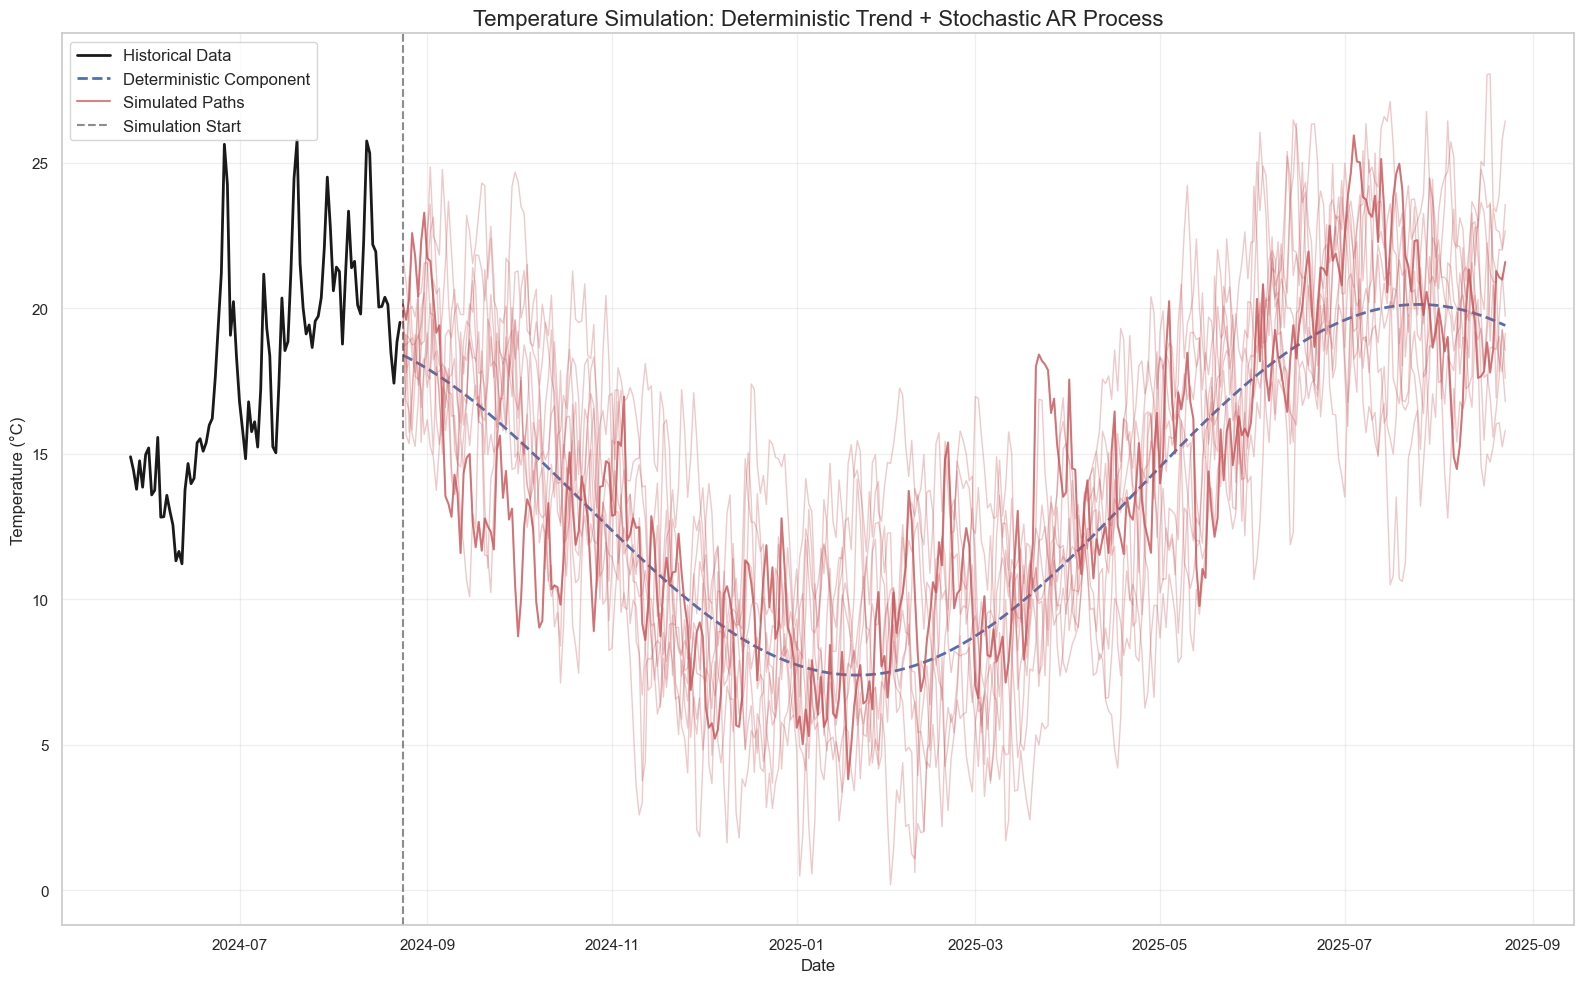

In [69]:
# Visualize the simulation results
plt.figure(figsize=(16, 10))

# Plot historical data for context
historical_days = 90  # Show the last 90 days of historical data
historical_start = daily_data['date'].max() - pd.Timedelta(days=historical_days-1)
historical_data = daily_data[daily_data['date'] >= historical_start]

plt.plot(historical_data['date'], historical_data['temperature_2m_mean'], 
         'k-', linewidth=2, label='Historical Data')

# Plot the deterministic component
plt.plot(simulated_temps['date'], simulated_temps['deterministic'], 
         'b--', linewidth=2, label='Deterministic Component')

# Plot each simulation path
for path in range(num_paths):
    plt.plot(simulated_temps['date'], simulated_temps[f'path_{path+1}'], 
             'r-', alpha=0.3, linewidth=1)

# Add a thicker line for one path to include in legend
plt.plot(simulated_temps['date'], simulated_temps['path_1'], 
         'r-', alpha=0.7, linewidth=1.5, label='Simulated Paths')

# Add vertical line at simulation start
plt.axvline(x=start_date, color='k', linestyle='--', alpha=0.5, 
            label='Simulation Start')

# Formatting
plt.title('Temperature Simulation: Deterministic Trend + Stochastic AR Process', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

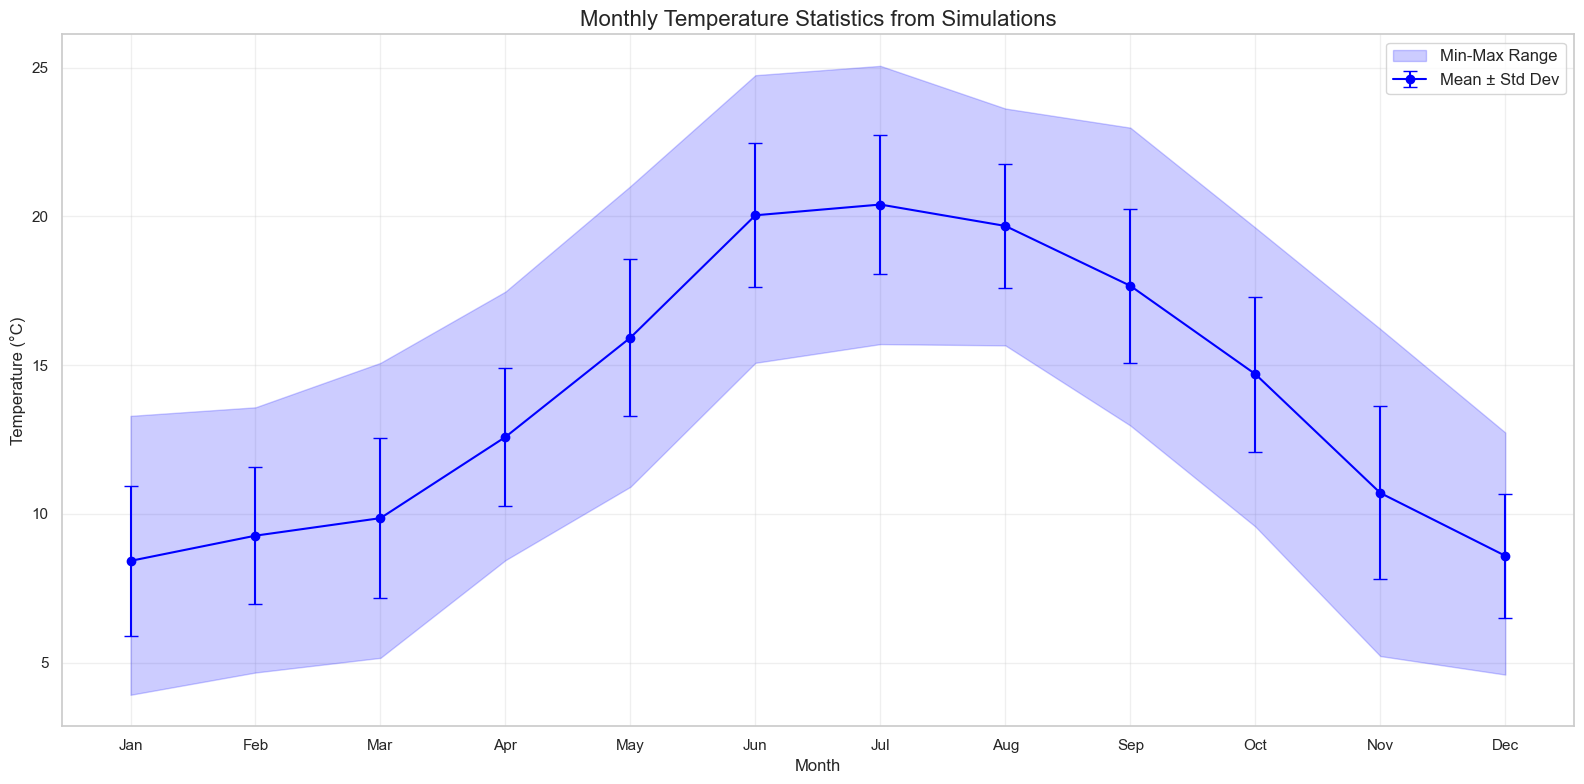

In [70]:
# Calculate and visualize statistics from the simulations
# Create monthly statistics
simulated_temps['month'] = simulated_temps['date'].dt.month
simulated_temps['year'] = simulated_temps['date'].dt.year

# Initialize arrays for statistics
monthly_means = np.zeros((12, num_paths))
monthly_stds = np.zeros((12, num_paths))
monthly_mins = np.zeros((12, num_paths))
monthly_maxs = np.zeros((12, num_paths))

# Calculate statistics for each month and path
for month in range(1, 13):
    for path in range(num_paths):
        path_data = simulated_temps[simulated_temps['month'] == month][f'path_{path+1}']
        if not path_data.empty:
            monthly_means[month-1, path] = path_data.mean()
            monthly_stds[month-1, path] = path_data.std()
            monthly_mins[month-1, path] = path_data.min()
            monthly_maxs[month-1, path] = path_data.max()

# Calculate average statistics across paths
avg_monthly_means = np.mean(monthly_means, axis=1)
avg_monthly_stds = np.mean(monthly_stds, axis=1)
avg_monthly_mins = np.mean(monthly_mins, axis=1)
avg_monthly_maxs = np.mean(monthly_maxs, axis=1)

# Plot monthly statistics
plt.figure(figsize=(16, 8))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x = np.arange(len(months))

plt.errorbar(x, avg_monthly_means, yerr=avg_monthly_stds, fmt='o-', 
             capsize=5, label='Mean ± Std Dev', color='blue')
plt.fill_between(x, avg_monthly_mins, avg_monthly_maxs, alpha=0.2, 
                 color='blue', label='Min-Max Range')

plt.title('Monthly Temperature Statistics from Simulations', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xticks(x, months)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

Hot temperature threshold (90th percentile): 18.76°C
Cold temperature threshold (10th percentile): 5.11°C

Extreme Temperature Days in Simulated Year:
Hot days (>18.76°C): 82.3 ± 14.9
Cold days (<5.11°C): 14.6 ± 10.3


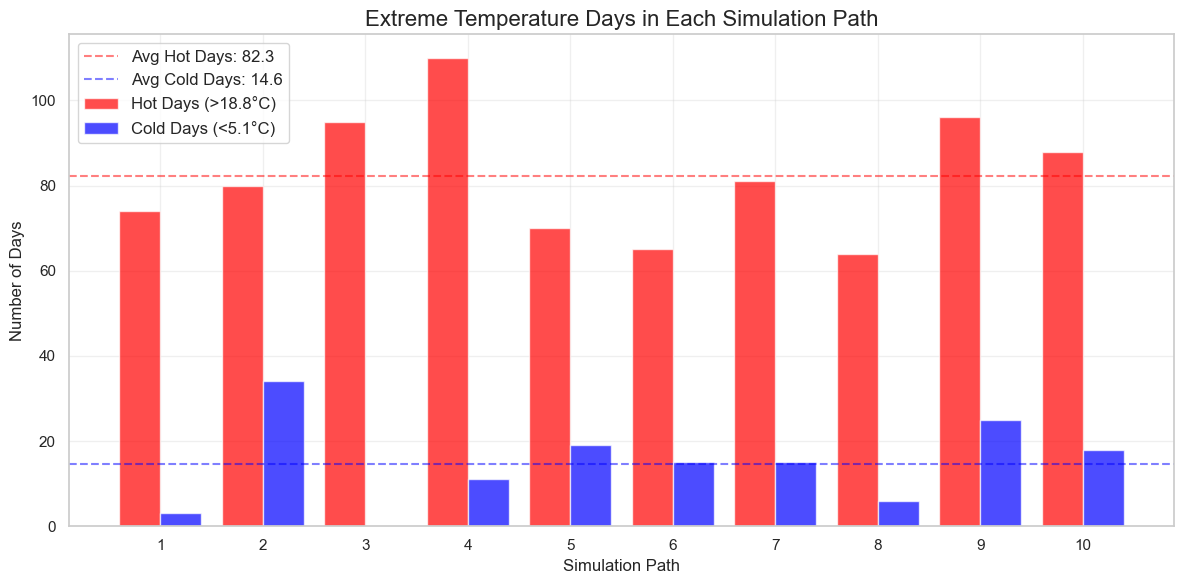

In [71]:
# Analyze extreme events in the simulations
# Calculate temperature thresholds 
hot_threshold = np.percentile(daily_data['temperature_2m_mean'], 90)
cold_threshold = np.percentile(daily_data['temperature_2m_mean'], 10)

print(f"Hot temperature threshold (90th percentile): {hot_threshold:.2f}°C")
print(f"Cold temperature threshold (10th percentile): {cold_threshold:.2f}°C")

# Count extreme days in each simulation path
extreme_days = pd.DataFrame(index=range(1, num_paths+1))
extreme_days['hot_days'] = 0
extreme_days['cold_days'] = 0

for path in range(num_paths):
    path_temps = simulated_temps[f'path_{path+1}']
    extreme_days.loc[path+1, 'hot_days'] = sum(path_temps > hot_threshold)
    extreme_days.loc[path+1, 'cold_days'] = sum(path_temps < cold_threshold)

# Calculate statistics
avg_hot_days = extreme_days['hot_days'].mean()
avg_cold_days = extreme_days['cold_days'].mean()
std_hot_days = extreme_days['hot_days'].std()
std_cold_days = extreme_days['cold_days'].std()

print(f"\nExtreme Temperature Days in Simulated Year:")
print(f"Hot days (>{hot_threshold:.2f}°C): {avg_hot_days:.1f} ± {std_hot_days:.1f}")
print(f"Cold days (<{cold_threshold:.2f}°C): {avg_cold_days:.1f} ± {std_cold_days:.1f}")

# Plot extreme day counts
plt.figure(figsize=(12, 6))
plt.bar(extreme_days.index - 0.2, extreme_days['hot_days'], width=0.4, 
        color='red', alpha=0.7, label=f'Hot Days (>{hot_threshold:.1f}°C)')
plt.bar(extreme_days.index + 0.2, extreme_days['cold_days'], width=0.4, 
        color='blue', alpha=0.7, label=f'Cold Days (<{cold_threshold:.1f}°C)')

plt.axhline(y=avg_hot_days, color='red', linestyle='--', alpha=0.5, 
            label=f'Avg Hot Days: {avg_hot_days:.1f}')
plt.axhline(y=avg_cold_days, color='blue', linestyle='--', alpha=0.5, 
            label=f'Avg Cold Days: {avg_cold_days:.1f}')

plt.title('Extreme Temperature Days in Each Simulation Path', fontsize=16)
plt.xlabel('Simulation Path', fontsize=12)
plt.ylabel('Number of Days', fontsize=12)
plt.xticks(range(1, num_paths+1))
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [72]:
# Weather Derivatives Pricing Module 

def calculate_degree_days(temperatures, threshold=18, mode='HDD'):
    """
    Calculate Heating Degree Days (HDD) or Cooling Degree Days (CDD)
    
    Parameters:
    -----------
    temperatures : array-like
        Daily temperature values
    threshold : float
        Reference temperature (typically 18°C)
    mode : str
        'HDD' for Heating Degree Days or 'CDD' for Cooling Degree Days
        
    Returns:
    --------
    Array of daily degree days
    """
    if mode.upper() == 'HDD':
        return np.maximum(threshold - temperatures, 0)
    elif mode.upper() == 'CDD':
        return np.maximum(temperatures - threshold, 0)
    else:
        raise ValueError("Mode must be either 'HDD' or 'CDD'")
# Modified pricing function with better timezone handling
def price_weather_derivatives(simulated_temps, contract_params, num_simulations=None):
    """
    Price various weather derivative contracts using Monte Carlo simulation
    
    Parameters:
    -----------
    simulated_temps : DataFrame
        DataFrame containing simulated temperature paths
    contract_params : dict
        Dictionary with contract parameters
    num_simulations : int, optional
        Number of simulations to use (if None, use all available paths)
        
    Returns:
    --------
    Dictionary with pricing results
    """
    # Extract contract parameters
    start_date = pd.to_datetime(contract_params.get('start_date'))
    end_date = pd.to_datetime(contract_params.get('end_date'))
    threshold = contract_params.get('threshold', 18)
    mode = contract_params.get('mode', 'HDD')
    discount_rate = contract_params.get('discount_rate', 0.0)  # Annual rate
    
    # Make a copy of the simulated_temps DataFrame
    sim_temps_copy = simulated_temps.copy()
    
    # Handle timezone differences
    if pd.api.types.is_datetime64tz_dtype(sim_temps_copy['date']):
        # If simulated dates have timezone but contract dates don't
        if start_date.tz is None:
            timezone = sim_temps_copy['date'].dt.tz
            start_date = start_date.tz_localize(timezone)
            end_date = end_date.tz_localize(timezone)
        # If both have timezones but they're different
        elif start_date.tz != sim_temps_copy['date'].iloc[0].tz:
            start_date = start_date.tz_convert(sim_temps_copy['date'].dt.tz)
            end_date = end_date.tz_convert(sim_temps_copy['date'].dt.tz)
    else:
        # If simulated dates don't have timezone but contract dates do
        if hasattr(start_date, 'tz') and start_date.tz is not None:
            start_date = start_date.tz_localize(None)
            end_date = end_date.tz_localize(None)
    
    # Filter dates for the contract period
    contract_temps = sim_temps_copy[(sim_temps_copy['date'] >= start_date) & 
                                   (sim_temps_copy['date'] <= end_date)].copy()
    
    # Check if we have data for the contract period
    if len(contract_temps) == 0:
        raise ValueError(f"No temperature data available for the contract period: {start_date} to {end_date}")
    
    # Determine how many simulation paths to use
    path_columns = [col for col in contract_temps.columns if col.startswith('path_')]
    if num_simulations is not None and num_simulations < len(path_columns):
        path_columns = path_columns[:num_simulations]
    
    # Calculate degree days for each path
    cumulative_dd = []
    daily_dd_paths = []
    
    for path in path_columns:
        # Calculate daily degree days
        daily_dd = calculate_degree_days(contract_temps[path], threshold, mode)
        daily_dd_paths.append(daily_dd)
        
        # Calculate cumulative degree days for the period
        cumulative_dd.append(np.sum(daily_dd))
    
    # Convert to arrays for easier calculations
    cumulative_dd = np.array(cumulative_dd)
    daily_dd_paths = np.array(daily_dd_paths)
    
    # Calculate discount factor
    days_to_maturity = (end_date - start_date).days
    discount_factor = np.exp(-discount_rate * days_to_maturity / 365)
    
    # Initialize results dictionary
    results = {
        'contract_period': f"{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}",
        'num_days': days_to_maturity + 1,
        'num_simulations': len(path_columns),
        'mode': mode,
        'threshold': threshold,
        'mean_dd': np.mean(cumulative_dd),
        'std_dd': np.std(cumulative_dd),
        'min_dd': np.min(cumulative_dd),
        'max_dd': np.max(cumulative_dd),
        'discount_factor': discount_factor,
        'daily_dd_paths': daily_dd_paths,
        'cumulative_dd': cumulative_dd,
        'options': {}
    }
    
    # 1. Call Option with Cap
    if 'call' in contract_params:
        call_params = contract_params['call']
        alpha = call_params.get('alpha', 1)
        strike = call_params.get('strike', 0)
        cap = call_params.get('cap', float('inf'))
        
        # Calculate payoffs
        payoffs = np.minimum(alpha * np.maximum(cumulative_dd - strike, 0), cap)
        price = discount_factor * np.mean(payoffs)
        
        results['options']['call'] = {
            'alpha': alpha,
            'strike': strike,
            'cap': cap,
            'price': price,
            'std_payoff': np.std(payoffs),
            'max_payoff': np.max(payoffs)
        }
    
    # 2. Put Option with Floor
    if 'put' in contract_params:
        put_params = contract_params['put']
        alpha = put_params.get('alpha', 1)
        strike = put_params.get('strike', 0)
        floor = put_params.get('floor', float('inf'))
        
        # Calculate payoffs
        payoffs = np.minimum(alpha * np.maximum(strike - cumulative_dd, 0), floor)
        price = discount_factor * np.mean(payoffs)
        
        results['options']['put'] = {
            'alpha': alpha,
            'strike': strike,
            'floor': floor,
            'price': price,
            'std_payoff': np.std(payoffs),
            'max_payoff': np.max(payoffs)
        }
    
    # 3. Collar
    if 'collar' in contract_params:
        collar_params = contract_params['collar']
        alpha = collar_params.get('alpha', 1)
        beta = collar_params.get('beta', 1)
        strike1 = collar_params.get('strike1', 0)
        strike2 = collar_params.get('strike2', 0)
        cap = collar_params.get('cap', float('inf'))
        floor = collar_params.get('floor', float('inf'))
        
        # Calculate payoffs
        call_part = np.minimum(alpha * np.maximum(cumulative_dd - strike1, 0), cap)
        put_part = np.minimum(beta * np.maximum(strike2 - cumulative_dd, 0), floor)
        payoffs = call_part - put_part
        price = discount_factor * np.mean(payoffs)
        
        results['options']['collar'] = {
            'alpha': alpha,
            'beta': beta,
            'strike1': strike1,
            'strike2': strike2,
            'cap': cap,
            'floor': floor,
            'price': price,
            'std_payoff': np.std(payoffs),
            'max_payoff': np.max(payoffs),
            'min_payoff': np.min(payoffs)
        }
    
    return results

In [73]:
# Example usage: Define contract parameters and price weather derivatives
# First, check the date range available in your simulated data
print(f"Simulated temperature data range: {simulated_temps['date'].min()} to {simulated_temps['date'].max()}")

# Get the timezone from the simulated data if it exists
timezone = None
if pd.api.types.is_datetime64tz_dtype(simulated_temps['date']):
    timezone = simulated_temps['date'].dt.tz
    print(f"Timezone in simulated data: {timezone}")

# Let's price contracts for the winter season within your simulation period
sim_start = simulated_temps['date'].min()
sim_end = simulated_temps['date'].max()

# Find a winter period within your simulation range
# Create timestamps with the same timezone as your simulation data
winter_start = pd.Timestamp('2023-12-01')
winter_end = pd.Timestamp('2024-02-28')  # Use Feb 28 to avoid leap year issues

# Ensure timezone consistency
if timezone is not None:
    # If simulation data has timezone, localize contract dates
    winter_start = winter_start.tz_localize(timezone)
    winter_end = winter_end.tz_localize(timezone)
else:
    # If simulation data doesn't have timezone, make sure contract dates don't either
    sim_start = sim_start.tz_localize(None) if hasattr(sim_start, 'tz') else sim_start
    sim_end = sim_end.tz_localize(None) if hasattr(sim_end, 'tz') else sim_end

# Make sure these dates are within your simulation period
if winter_start < sim_start:
    # Move to next winter if needed
    next_year = winter_start.year + 1
    winter_start = pd.Timestamp(f"{next_year}-12-01")
    
    # Check if the next year + 1 is a leap year
    import calendar
    is_leap_year = calendar.isleap(next_year + 1)
    
    # Set the end date based on whether it's a leap year
    if is_leap_year:
        winter_end = pd.Timestamp(f"{next_year + 1}-02-29")
    else:
        winter_end = pd.Timestamp(f"{next_year + 1}-02-28")
    
    # Apply timezone if needed
    if timezone is not None:
        winter_start = winter_start.tz_localize(timezone)
        winter_end = winter_end.tz_localize(timezone)

# Check if the winter period is within the simulation range
if winter_end > sim_end:
    # If not, use the first 90 days of the simulation as a substitute
    print("Warning: Desired winter period is outside simulation range.")
    print("Using first 90 days of simulation instead.")
    winter_start = sim_start
    winter_end = sim_start + pd.Timedelta(days=90)

print(f"Contract period: {winter_start} to {winter_end}")

# Define the contract parameters
contract_params = {
    'start_date': winter_start,  # Start of winter
    'end_date': winter_end,      # End of winter
    'threshold': 18,             # Reference temperature (18°C)
    'mode': 'HDD',               # Heating Degree Days
    'discount_rate': 0.03,       # 3% annual discount rate
    
    # Call option parameters
    'call': {
        'alpha': 10,             # €10 per degree day
        'strike': 900,           # Strike of 900 HDDs
        'cap': 5000              # Maximum payout of €5,000
    },
    
    # Put option parameters
    'put': {
        'alpha': 10,             # €10 per degree day
        'strike': 700,           # Strike of 700 HDDs
        'floor': 3000            # Maximum payout of €3,000
    },
    
    # Collar parameters
    'collar': {
        'alpha': 10,             # €10 per degree day for long call
        'beta': 8,               # €8 per degree day for short put
        'strike1': 800,          # Call strike
        'strike2': 600,          # Put strike
        'cap': 4000,             # Call cap of €4,000
        'floor': 2000            # Put floor of €2,000
    }
}

# Price the weather derivatives using our simulated temperature paths
try:
    pricing_results = price_weather_derivatives(simulated_temps, contract_params)

    # Display the results
    print(f"Contract Period: {pricing_results['contract_period']} ({pricing_results['num_days']} days)")
    print(f"Mode: {pricing_results['mode']} with {pricing_results['threshold']}°C threshold")
    print(f"Simulations: {pricing_results['num_simulations']}")
    print(f"\nCumulative Degree Days Statistics:")
    print(f"Mean: {pricing_results['mean_dd']:.2f}")
    print(f"Std Dev: {pricing_results['std_dd']:.2f}")
    print(f"Range: [{pricing_results['min_dd']:.2f}, {pricing_results['max_dd']:.2f}]")

    print("\nOption Prices:")
    for option_type, details in pricing_results['options'].items():
        print(f"\n{option_type.capitalize()} Option:")
        for key, value in details.items():
            if isinstance(value, (int, float)):
                print(f"  {key}: {value:.2f}")
            else:
                print(f"  {key}: {value}")
except ValueError as e:
    print(f"Error: {e}")
    print("\nPlease adjust the contract dates to be within your simulation period.")

Simulated temperature data range: 2024-08-24 00:00:00+00:00 to 2025-08-23 00:00:00+00:00
Timezone in simulated data: UTC
Contract period: 2024-12-01 00:00:00+00:00 to 2025-02-28 00:00:00+00:00
Contract Period: 2024-12-01 to 2025-02-28 (90 days)
Mode: HDD with 18°C threshold
Simulations: 10

Cumulative Degree Days Statistics:
Mean: 832.81
Std Dev: 123.74
Range: [613.19, 1062.42]

Option Prices:

Call Option:
  alpha: 10.00
  strike: 900.00
  cap: 5000.00
  price: 255.56
  std_payoff: 499.99
  max_payoff: 1624.22

Put Option:
  alpha: 10.00
  strike: 700.00
  floor: 3000.00
  price: 86.18
  std_payoff: 260.43
  max_payoff: 868.10

Collar Option:
  alpha: 10.00
  beta: 8.00
  strike1: 800.00
  strike2: 600.00
  cap: 4000.00
  floor: 2000.00
  price: 670.92
  std_payoff: 853.21
  max_payoff: 2624.22
  min_payoff: 0.00


C:\Users\Lucas\AppData\Local\Temp\ipykernel_18204\4011549521.py:7: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(simulated_temps['date']):
C:\Users\Lucas\AppData\Local\Temp\ipykernel_18204\807658341.py:55: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(sim_temps_copy['date']):
